Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted 

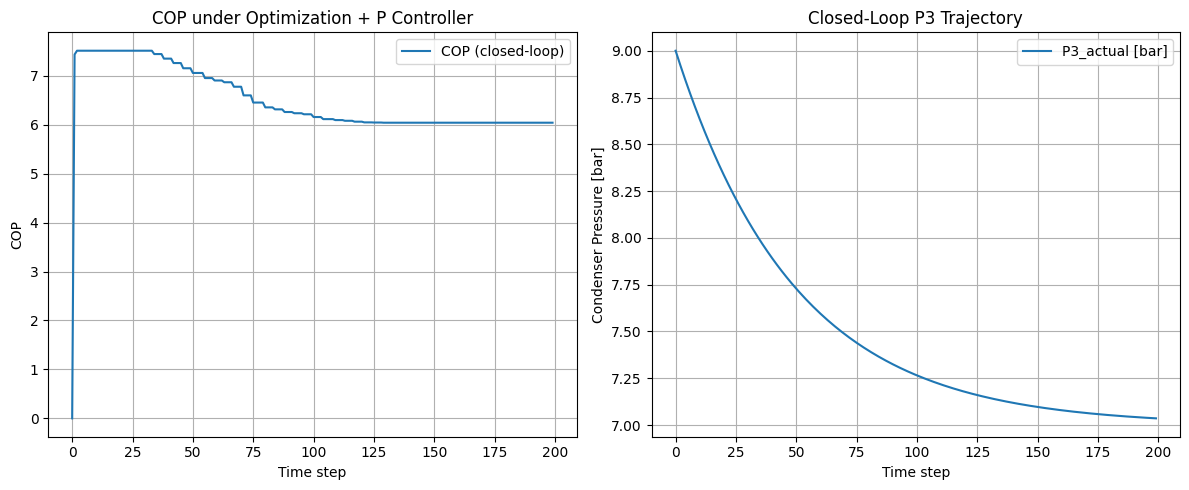

In [ ]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load trained Random Forest model
# -----------------------------
rf = joblib.load("rf_cop_model.pkl")

# -----------------------------
# 2. Parameters
# -----------------------------
Te = 278            # Evaporator temp [K]
SH = 10             # Superheat [K]
SC = 5              # Subcooling [K]
eta_comp = 0.75     # Compressor efficiency

# Condenser pressure limits
P3_min = 700e3      # Pa
P3_max = 1600e3     # Pa

# Closed-loop controller parameters
Kp = 0.1            # proportional gain
tau = 5.0           # system time constant [s]
dt = 1.0            # timestep [s]
N = 200             # number of timesteps

# Ambient disturbance (condenser temperature)
Tc_series = np.linspace(305, 325, N)  # 32°C → 52°C

# -----------------------------
# 3. COP prediction function
# -----------------------------
def predict_cop(Te, Tc, SH, SC, P3):
    X = np.array([[Te, Tc, SH, SC, P3]])
    return rf.predict(X)[0] * eta_comp  # scale by compressor efficiency

# -----------------------------
# 4. Grid-based optimization (fast)
# -----------------------------
def optimize_P3_grid(Te, Tc, SH, SC):
    P3_vals = np.linspace(P3_min, P3_max, 30)
    COP_vals = [predict_cop(Te, Tc, SH, SC, P) for P in P3_vals]
    idx_max = np.argmax(COP_vals)
    return P3_vals[idx_max], COP_vals[idx_max]

# -----------------------------
# 5. Initialize arrays
# -----------------------------
P3_actual = np.zeros(N)
COP_actual = np.zeros(N)

P3_actual[0] = 900e3  # Initial condenser pressure [Pa]

# -----------------------------
# 6. Simulation loop
# -----------------------------
for t in range(1, N):
    Tc = Tc_series[t]

    # Step 1: compute optimal P3 using fast grid
    P3_opt, COP_opt = optimize_P3_grid(Te, Tc, SH, SC)

    # Step 2: proportional control + first-order dynamics
    dP = Kp * (P3_opt - P3_actual[t-1])
    P3_actual[t] = P3_actual[t-1] + dt * dP / tau

    # Step 3: compute COP at actual pressure
    COP_actual[t] = predict_cop(Te, Tc, SH, SC, P3_actual[t])

# -----------------------------
# 7. Plot results
# -----------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(COP_actual, label="COP (closed-loop)")
plt.xlabel("Time step")
plt.ylabel("COP")
plt.title("COP under Optimization + P Controller")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(P3_actual/1e5, label="P3_actual [bar]")
plt.xlabel("Time step")
plt.ylabel("Condenser Pressure [bar]")
plt.title("Closed-Loop P3 Trajectory")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
